In [200]:
## AUXILIAR: IMPORTS GLOBALES
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [201]:
## AUXILIAR: Muestra los resultados de cada modelo.

def show_results(clasificador_real, clasificador_predicho, title):
    print(f"\n{title}:")
    print("Accuracy :", accuracy_score(clasificador_real, clasificador_predicho))
    print("Precision:", precision_score(clasificador_real, clasificador_predicho, pos_label=0))
    print("Recall   :", recall_score(clasificador_real, clasificador_predicho, pos_label=0))
    print("F1 Score :", f1_score(clasificador_real, clasificador_predicho, pos_label=0))

    print("\nMatriz de confusión:")
    print(confusion_matrix(clasificador_real, clasificador_predicho))

In [202]:
## AUXILIAR: División en training set y test set. (Split 80-20)

""" 
Dado que el desbalanceo del dataset es casi inexistente,
se aplicará directamente una división 80-20.
"""

def split_80_20(dataset: pd.DataFrame):
    # Separar atributos y atributo clasificador del dataset transformado.
    atributos = dataset.drop("Personality", axis=1)
    clasificador = dataset["Personality"]

    # Dividir en 80% entrenamiento, 20% test.

    """
    test_size=0.2 Significa que el 20% del dataset se usa para testing, y lo restante para training.
    random_state=42 Es una seed para generar números aleatorios, permite que el split sea reproducible (siempre da la misma división exacta). Si no se coloca nada, en cada ejecución divide distinto.
    stratify=clasificador Sirve para mantener la proporción de clases igual en ambos sets. Es decir, si tengo 52% de extrovertidos y 48% de introvertidos en el dataset, al dividirlo el training set y el test set tendrán ese mismo balance. Sin esto, puede pasar que el test set termine con muchas más instancias de una clase.
    """

    atributos_train, atributos_test, clasificador_train, clasificador_test = train_test_split(
        atributos, clasificador, 
        test_size=0.2, random_state=42, 
        stratify=clasificador
    )

    return atributos_train, atributos_test, clasificador_train, clasificador_test


In [203]:
## AUXILIAR: Verificar desbalanceo de dataset

def verificar_desbalanceo(dataset):
    # Revisar desbalanceo del dataset.
    print("\nPorcentaje de casos que hay en cada clase de atributo clasificador:")
    print(dataset["Personality"].value_counts(normalize=True))

    # Verificación gráfica
    dataset["Personality"].value_counts().plot(kind="bar", title="Distribución de clases", color=["steelblue", "salmon"])
    plt.xticks(rotation=0)
    plt.ylabel("Cantidad")
    plt.xlabel("Clase (0 = Introvertido, 1 = Extrovertido)")
    plt.grid(axis='y')
    plt.show()

In [204]:
# Carga de datos.
dataset = pd.read_csv('../datasets/personality.csv')

#### LIMPIEZA
Se revisan tipos, nulos y duplicados para asegurar consistencia del dataset.

Se imputan numéricas con mediana (robusta a outliers) y categóricas con moda (categoría representativa) para no perder filas.

In [205]:
# Análisis Exploratorio.

print("\nInfo general del dataset:")
dataset.head()
dataset.info()

print("\nValores faltantes por atributo:")
print(dataset.isnull().sum().sort_values(ascending=False))

print("Filas duplicadas:", dataset.duplicated().sum())


Info general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB

Valores faltantes por atributo:
Friends_circle_size          77
Stage_fear                   73
Going_outside                66
Post_frequency               65
Time_spent_Alone             63
Social_event_attendance      62
Drained_after_socializing   


Porcentaje de casos que hay en cada clase de atributo clasificador:
Personality
Extrovert    0.514138
Introvert    0.485862
Name: proportion, dtype: float64


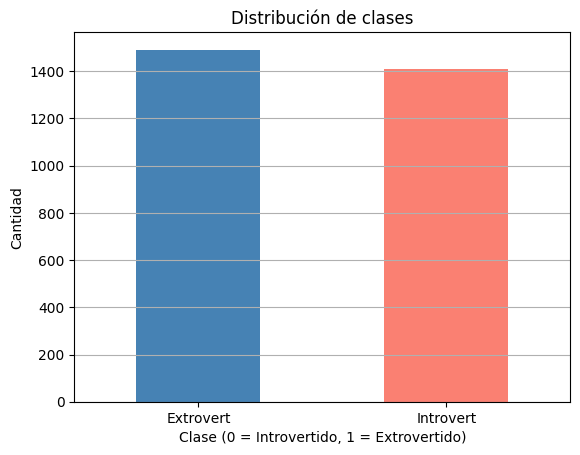

In [206]:
# Verificar desbalanceo de dataset
verificar_desbalanceo(dataset)

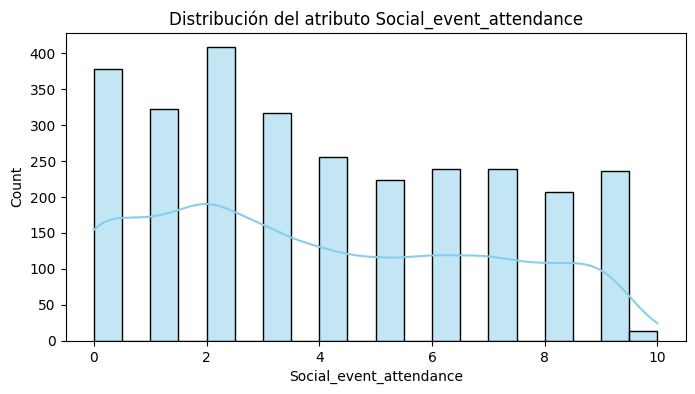

In [207]:
# Análisis de distribución.

"""
Dependiendo si hay una distribución simétrica (normal) o asimétrica
para cada atributo numérico con valores nulos, puedo ver si usar la media
o la mediana a la hora de imputar dichos valores.
"""

columna = 'Social_event_attendance'

plt.figure(figsize=(8,4))
sns.histplot(dataset[columna], kde=True, bins=20, color='skyblue')
plt.title(f"Distribución del atributo {columna}")
plt.show()

Filas duplicadas: 0

Porcentaje de casos que hay en cada clase de atributo clasificador:
Personality
Extrovert    0.564092
Introvert    0.435908
Name: proportion, dtype: float64


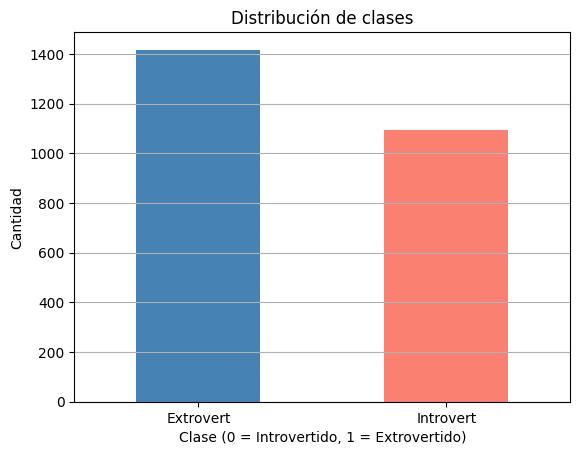

In [208]:
# Eliminar duplicados

dataset = dataset.drop_duplicates(keep='first')
print("Filas duplicadas:", dataset.duplicated().sum())

# Verificar desbalanceo de dataset
verificar_desbalanceo(dataset)

In [209]:
# Imputación.

""" 
Se proceden a imputar los valores nulos de los atributos del dataset.
- Para atributos continuos, se utilizará la mediana.
- Para atributos categóricos, se utilizará la moda.
"""

# Columnas numéricas.
numeric_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
            'Friends_circle_size', 'Post_frequency']

for columna in numeric_cols:
    mediana = dataset[columna].median()
    dataset[columna] = dataset[columna].fillna(mediana)

# Columnas categóricas.
categoric_cols = ['Stage_fear', 'Drained_after_socializing']

for columna in categoric_cols:
    moda = dataset[columna].mode()[0]
    dataset[columna] = dataset[columna].fillna(moda)

# Verificación.
print("\nValores faltantes por atributo:")
print(dataset.isnull().sum())


Valores faltantes por atributo:
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64


#### INTEGRACIÓN
No se integraron fuentes externas; todo el análisis se realiza sobre un único CSV consistente.

Si se sumaran tablas adicionales, acá se unificarían y reconciliarían claves.

#### SELECCIÓN
No fue necesario quitar ninguna columna, se analizó y concluyó que todas eran representativas para poder predecir si
una persona es extrovertida o introvertida.

#### TRANSFORMACIÓN
Se convierten las variables al formato requerido por los algoritmos:
- Los atributos categóricos simples y el atributo clasificador pasan por codificación binaria.

El escalado se realiza dentro de los pipelines y solo con el train para evitar data leakage.

In [210]:
""" 
Se aplica una transformación binaria dado que son atributos categóricos simples.
No son multiclase. Si lo fueran se utilizaría:
- One hot encoding (para clases sin orden).
- Label encoding (para clases con orden).
Se aplica un escalado para atributos continuos que será realizado en los respectivos
training set para evitar data leakage.
"""

# Transformación binaria para atributos.
dataset["Stage_fear"] = dataset["Stage_fear"].map({ 'Yes': 1, 'No': 0 })
dataset["Drained_after_socializing"] = dataset["Drained_after_socializing"].map({ 'Yes': 1, 'No': 0 })

# Transformación binaria para atributo clasificador.
dataset["Personality"] = dataset["Personality"].map({ 'Extrovert': 1, 'Introvert': 0 })

dataset.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,0,4.0,6.0,0,13.0,5.0,1
1,9.0,1,0.0,0.0,1,0.0,3.0,0
2,9.0,1,1.0,2.0,1,5.0,2.0,0
3,0.0,0,6.0,7.0,0,14.0,8.0,1
4,3.0,0,9.0,4.0,0,8.0,5.0,1


In [211]:
"""
Se aplica un escalado con StandardScaler() para los atributos continuos.
Este escalado se aplica en el training set al momento de hacer el split, y no
en todo el dataset dado que provoca filtración de data y eso puede sesgar las métricas
de los modelos (el test set gana información sobre el training set que no debería saber).
"""

'\nSe aplica un escalado con StandardScaler() para los atributos continuos.\nEste escalado se aplica en el training set al momento de hacer el split, y no\nen todo el dataset dado que provoca filtración de data y eso puede sesgar las métricas\nde los modelos (el test set gana información sobre el training set que no debería saber).\n'

#### MINERÍA Y EVALUACIÓN
Se entrenan tres algoritmos (Logistic Regression, Random Forest y KNN) con tres enfoques:
- Split 80/20.
- Cross-validation.
- Cross-validation + Grid search.

Se reportan las siguientes métricas:
- Accuracy (Métrica principal)
- Precision
- Recall
- F1 Score
- Matriz de confusión

In [212]:
## REGRESIÓN LOGÍSTICA:

""" 
Se genera un pipeline el cual procura que el modelo ESCALE los valores continuos
SOLO en cada respectivo training set, esto evita que haya filtrado de data en el
test set y el modelo dé métricas un poco sesgadas.
"""

pipe_LR = Pipeline([
    ("continuos", StandardScaler()),
    ("modelo", LogisticRegression(random_state=42, max_iter=1000))
])

In [213]:
## Primera iteración: Regresión logística Split 80-20

atributos_train, atributos_test, clasificador_train, clasificador_test = split_80_20(dataset)

# Entrenar con el training set
pipe_LR.fit(atributos_train, clasificador_train)

# Predecir sobre el test set
clasificador_predicho = pipe_LR.predict(atributos_test)

# Evaluar resultados
show_results(clasificador_test, clasificador_predicho, title="Regresión Logística - Split 80/20")


Regresión Logística - Split 80/20:
Accuracy : 0.9005964214711729
Precision: 0.9203980099502488
Recall   : 0.8447488584474886
F1 Score : 0.8809523809523809

Matriz de confusión:
[[185  34]
 [ 16 268]]


In [214]:
## Segunda iteración: Regresión logística Cross-validation

atributos = dataset.drop("Personality", axis=1)
clasificador = dataset["Personality"]

# Cross-validation estratificada (para mantener la misma proporción de clases)
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clasificador_predicho = cross_val_predict(
    estimator=pipe_LR,
    X=atributos,
    y=clasificador,
    cv=cv5,
    n_jobs=-1
)

# Evaluar resultados
show_results(clasificador, clasificador_predicho, title="Regresión Logística - Cross-validation")


Regresión Logística - Cross-validation:
Accuracy : 0.910031847133758
Precision: 0.9026876737720111
Recall   : 0.8894977168949771
F1 Score : 0.8960441582336707

Matriz de confusión:
[[ 974  121]
 [ 105 1312]]


In [215]:
## Tercera iteración: Regresión logística Cross-validation + Grid Search

# Hiperparámetros a probar con Grid Search
parametros_LR = {
    "modelo__C": [0.01, 0.1, 1, 10, 100],
    "modelo__penalty": ["l2"],
    "modelo__solver": ["lbfgs", "liblinear"]
}

# Cross-validation estratificada (para mantener la misma proporción de clases)
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_LR = GridSearchCV(
    estimator=pipe_LR,
    param_grid=parametros_LR,
    scoring="accuracy",
    cv=cv5,
    return_train_score=False,
    n_jobs=-1
)

# Ajuste con el training
grid_LR.fit(atributos, clasificador)
print("Mejor combinación de hiperparámetros [Regresión Logística]:")
print(grid_LR.best_params_)

# Modelo optimizado
mejor_LR = grid_LR.best_estimator_

clasificador_predicho = cross_val_predict(
    estimator=mejor_LR,
    X=atributos,
    y=clasificador,
    cv=cv5,
    n_jobs=-1
)

# Evaluar resultados
show_results(clasificador, clasificador_predicho, title="Regresión Logística - Cross-validation + Grid Search")

Mejor combinación de hiperparámetros [Regresión Logística]:
{'modelo__C': 0.01, 'modelo__penalty': 'l2', 'modelo__solver': 'lbfgs'}

Regresión Logística - Cross-validation + Grid Search:
Accuracy : 0.9267515923566879
Precision: 0.9063336306868867
Recall   : 0.9278538812785389
F1 Score : 0.9169675090252708

Matriz de confusión:
[[1016   79]
 [ 105 1312]]


In [216]:
## RANDOM FOREST:

"""
Se genera un pipeline que mantiene el mismo patrón que en Regresión Logística.
En Random Forest el escalado no es necesario, pero lo dejamos para mantener
una estructura uniforme y evitar cambios entre iteraciones.
"""

pipe_RF = Pipeline([
    ("continuos", StandardScaler()),
    ("modelo", RandomForestClassifier(random_state=42))
])

In [217]:
## Primera iteración: Random Forest Split 80-20

# División en training y test (usa tu helper existente)
atributos_train, atributos_test, clasificador_train, clasificador_test = split_80_20(dataset)

# Entrenar con el training set
pipe_RF.fit(atributos_train, clasificador_train)

# Predecir sobre el test set
clasificador_predicho = pipe_RF.predict(atributos_test)

# Evaluar resultados
show_results(clasificador_test, clasificador_predicho, title="Random Forest - Split 80/20")


Random Forest - Split 80/20:
Accuracy : 0.8926441351888668
Precision: 0.9104477611940298
Recall   : 0.8356164383561644
F1 Score : 0.8714285714285714

Matriz de confusión:
[[183  36]
 [ 18 266]]


In [218]:
## Segunda iteración: Random Forest Cross-validation

atributos = dataset.drop("Personality", axis=1)
clasificador = dataset["Personality"]

# Cross-validation estratificada (para mantener la misma proporción de clases)
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clasificador_predicho = cross_val_predict(
    estimator=pipe_RF,
    X=atributos,
    y=clasificador,
    cv=cv5,
    n_jobs=-1
)

# Evaluar resultados
show_results(clasificador, clasificador_predicho, title="Random Forest - Cross-validation")


Random Forest - Cross-validation:
Accuracy : 0.9012738853503185
Precision: 0.889604415823367
Recall   : 0.8831050228310502
F1 Score : 0.8863428047662695

Matriz de confusión:
[[ 967  128]
 [ 120 1297]]


In [219]:
## Tercera iteración: Random Forest Cross-validation + Grid Search

# Hiperparámetros a probar con Grid Search
parametros_RF = {
    "modelo__n_estimators": [50, 100, 150, 200, 250, 300],
    "modelo__max_depth": [5, 10, 15, 20, 25, 30],
    # "modelo__min_samples_split": [2, 5, 10],
    # "modelo__min_samples_leaf": [1, 2, 4],
    # "modelo__max_features": ["sqrt", "log2", None]
}

# Cross-validation estratificada (para mantener la misma proporción de clases)
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_RF = GridSearchCV(
    estimator=pipe_RF,
    param_grid=parametros_RF,
    scoring="accuracy",
    cv=cv5,
    return_train_score=False,
    n_jobs=-1
)

# Ajuste con el training
grid_RF.fit(atributos, clasificador)
print("Mejor combinación de hiperparámetros [Random Forest]:")
print(grid_RF.best_params_)

# Modelo optimizado
mejor_RF = grid_RF.best_estimator_

clasificador_predicho = cross_val_predict(
    estimator=mejor_RF,
    X=atributos,
    y=clasificador,
    cv=cv5,
    n_jobs=-1
)

# Evaluar resultados
show_results(clasificador, clasificador_predicho, title="Random Forest - Cross-validation + Grid Search")

Mejor combinación de hiperparámetros [Random Forest]:
{'modelo__max_depth': 5, 'modelo__n_estimators': 50}

Random Forest - Cross-validation + Grid Search:
Accuracy : 0.9271496815286624
Precision: 0.9064171122994652
Recall   : 0.9287671232876712
F1 Score : 0.9174560216508796

Matriz de confusión:
[[1017   78]
 [ 105 1312]]


In [220]:
## K-NEAREST NEIGHBORS:

"""
Se genera un pipeline que escala los atributos antes de KNN.
En KNN el escalado es CRÍTICO porque las distancias se distorsionan si las
variables tienen magnitudes diferentes. El pipeline evita fuga de datos.
"""

pipe_KNN = Pipeline([
    ("continuos", StandardScaler()),
    ("modelo", KNeighborsClassifier())
])

In [221]:
## Primera iteración: KNN Split 80-20

# División en training y test
atributos_train, atributos_test, clasificador_train, clasificador_test = split_80_20(dataset)

# Entrenar con el training set
pipe_KNN.fit(atributos_train, clasificador_train)

# Predecir sobre el test set
clasificador_predicho = pipe_KNN.predict(atributos_test)

# Evaluar resultados
show_results(clasificador_test, clasificador_predicho, title="K-Nearest Neighbors - Split 80/20")


K-Nearest Neighbors - Split 80/20:
Accuracy : 0.9105367793240556
Precision: 0.9182692307692307
Recall   : 0.8721461187214612
F1 Score : 0.8946135831381733

Matriz de confusión:
[[191  28]
 [ 17 267]]


In [222]:
## Segunda iteración: KNN Cross-validation

atributos = dataset.drop("Personality", axis=1)
clasificador = dataset["Personality"]

# Cross-validation estratificada (misma proporción de clases en cada fold)
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clasificador_predicho = cross_val_predict(
    estimator=pipe_KNN,
    X=atributos,
    y=clasificador,
    cv=cv5,
    n_jobs=-1
)

# Evaluar resultados
show_results(clasificador, clasificador_predicho, title="K-Nearest Neighbors - Cross-validation")


K-Nearest Neighbors - Cross-validation:
Accuracy : 0.9195859872611465
Precision: 0.9011680143755616
Recall   : 0.9159817351598174
F1 Score : 0.9085144927536232

Matriz de confusión:
[[1003   92]
 [ 110 1307]]


In [226]:
## Tercera iteración: KNN Cross-validation + Grid Search

# Hiperparámetros a probar con Grid Search
parametros_KNN = {
    "modelo__n_neighbors": [3, 5, 7, 9, 11],
    "modelo__weights": ["uniform", "distance"],
    "modelo__metric": ["euclidean", "manhattan"]
}

# Cross-validation estratificada (para mantener la misma proporción de clases)
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_KNN = GridSearchCV(
    estimator=pipe_KNN,
    param_grid=parametros_KNN,
    scoring="accuracy",
    cv=cv5,
    return_train_score=False,
    n_jobs=-1
)

# Ajuste con el training
grid_KNN.fit(atributos, clasificador)
print("Mejor combinación de hiperparámetros [KNN]:")
print(grid_KNN.best_params_)

# Modelo optimizado
mejor_KNN = grid_KNN.best_estimator_

clasificador_predicho = cross_val_predict(
    estimator=mejor_KNN,
    X=atributos,
    y=clasificador,
    cv=cv5,
    n_jobs=-1
)

show_results(clasificador, clasificador_predicho, title="K-Nearest Neighbors - Cross-validation + Grid Search")

Mejor combinación de hiperparámetros [KNN]:
{'modelo__metric': 'euclidean', 'modelo__n_neighbors': 11, 'modelo__weights': 'uniform'}

K-Nearest Neighbors - Cross-validation + Grid Search:
Accuracy : 0.9263535031847133
Precision: 0.9048042704626335
Recall   : 0.9287671232876712
F1 Score : 0.9166291122127084

Matriz de confusión:
[[1017   78]
 [ 107 1310]]
